# Find associations between merchant and customer fraud probabilities

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
from functools import reduce

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import countDistinct, col
import pyspark.sql.functions as F

In [2]:
sp = SparkSession.builder.appName("Fraud detection").getOrCreate()

22/10/04 12:03:35 WARN Utils: Your hostname, Harshitas-MacBook-Air-8.local resolves to a loopback address: 127.0.0.1; using 10.13.133.97 instead (on interface en0)
22/10/04 12:03:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/04 12:03:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
def merge_folder(trans_group: str):
    """
    Function to merge everything within yellow or green or fhvhv
    """
    dir = "../data/tables/" + trans_group +"/"
    folder_locs = os.listdir(dir)

    group_list = []
    for folder in folder_locs:
        path = dir + "/" + folder
        if os.path.isdir(path):
            # print("At current path", path)
            group_list.append(sp.read.parquet(path))

    return reduce(DataFrame.unionAll, group_list)

In [4]:
dir = "../data/tables/"
groups = ["transactions_20210228_20210827_snapshot/", "transactions_20210828_20220227_snapshot/", "transactions_20220228_20220828_snapshot/"]

final_list = []
for g in groups:
    print("Started group: ", g)
    final_list.append(sp.read.parquet(dir + g))

transactions = reduce(DataFrame.unionAll, final_list)

Started group:  transactions_20210228_20210827_snapshot/


Started group:  transactions_20210828_20220227_snapshot/


Started group:  transactions_20220228_20220828_snapshot/


In [5]:
merch = sp.read.parquet("../data/tables/tbl_merchants.parquet")
cust  = sp.read.option("header", True).option("delimiter", "|") \
        .csv("../data/tables/tbl_consumer.csv")

In [10]:
from pyspark.sql.types import DoubleType

cFraud = sp.read.option("header", True).csv("../data/tables/consumer_fraud_probability.csv")
cFraud = cFraud.withColumn("c_fraud_prob", col("fraud_probability").cast(DoubleType())).drop("fraud_probability")
# cFraud.show(3)
# cFraud.count()

In [11]:
mFraud = sp.read.option("header", True).csv("../data/tables/merchant_fraud_probability.csv")
mFraud = mFraud.withColumn("m_fraud_prob", col("fraud_probability").cast(DoubleType())).drop("fraud_probability")
# mFraud.show(3)
# mFraud.count()

Add merchant and customer fraud probabilities as new columns to transactions

In [12]:
trans_mc = transactions.join(mFraud, ['merchant_abn', 'order_datetime']) 
trans_mc = trans_mc.join(cFraud, ['user_id', 'order_datetime']) 

In [13]:
print("Number of rows after join: ", trans_mc.count())
trans_mc.show(3)

Number of rows after join:  440


+-------+--------------+------------+------------------+--------------------+-----------------+------------------+
|user_id|order_datetime|merchant_abn|      dollar_value|            order_id|     m_fraud_prob|      c_fraud_prob|
+-------+--------------+------------+------------------+--------------------+-----------------+------------------+
|   3101|    2021-04-17| 91880575299|105193.88578925544|2ab65c8f-11b2-41c...|32.99497823665355| 91.42192091901347|
|  19453|    2021-03-25| 83199298021|13887.358607198637|4d1ee9ac-2858-46d...|69.08556869902988|24.695211222609117|
|   2550|    2021-03-25| 83199298021| 37808.99908305577|bf73265f-fcd0-4f0...|69.08556869902988|55.876832987364644|
+-------+--------------+------------+------------------+--------------------+-----------------+------------------+
only showing top 3 rows



In [21]:
# compute avg customer fraud probabilities for each merchant
agg_probability = trans_mc \
    .groupBy('merchant_abn', 'm_fraud_prob', 'order_datetime') \
    .agg(F.mean('c_fraud_prob'), F.count('c_fraud_prob')) \
    .withColumnRenamed('avg(c_fraud_prob)', 'avg_cust_fraud') \
    .withColumnRenamed('count(c_fraud_prob)', 'cust_count')
agg_probability.show(5)

+------------+------------------+--------------+------------------+----------+
|merchant_abn|      m_fraud_prob|order_datetime|    avg_cust_fraud|cust_count|
+------------+------------------+--------------+------------------+----------+
| 91880575299| 32.99497823665355|    2021-04-17| 91.42192091901347|         1|
| 83199298021| 69.08556869902988|    2021-03-25|40.286022104986884|         2|
| 21439773999|28.504479048104585|    2021-11-26|16.901131702270927|        11|
| 43083074133| 48.66890735193894|    2021-12-18| 71.74055115445599|         3|
| 48534649627| 28.36052168812278|    2021-11-29|17.002857681418757|         6|
+------------+------------------+--------------+------------------+----------+
only showing top 5 rows



In [23]:
x = [val.m_fraud_prob for val in agg_probability.select('m_fraud_prob').collect()]
y = [val.avg_cust_fraud for val in agg_probability.select('avg_cust_fraud').collect()]

<AxesSubplot:xlabel='m_fraud_prob', ylabel='avg_cust_fraud'>

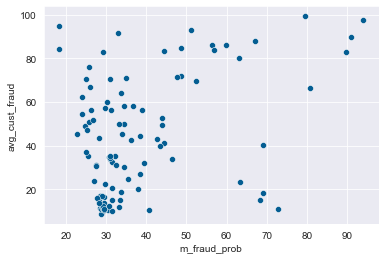

In [38]:
pandas_df = agg_probability.toPandas()

sns.set_style("darkgrid")
sns.set_palette("PuBu_r")
sns.scatterplot(data=pandas_df, x='m_fraud_prob', y='avg_cust_fraud')

Aggregate just customer fraud probabilities this time, leaving merchant fraud out

In [17]:
trans_c = transactions.join(cFraud, ['user_id', 'order_datetime']) 
print("Number of rows after join: ", trans_c.count())
trans_c.show(3)

Number of rows after join:  80560
+-------+--------------+------------+------------------+--------------------+------------------+
|user_id|order_datetime|merchant_abn|      dollar_value|            order_id|      c_fraud_prob|
+-------+--------------+------------+------------------+--------------------+------------------+
|    448|    2021-08-20| 94380689142| 6263.028459455749|23ec3af2-f20d-422...|14.681703172388145|
|    448|    2021-08-20| 41705715409| 137.1238996949634|fd03b72d-2835-40f...|14.681703172388145|
|    448|    2021-08-20| 27086915609|144.94739256786497|413bbb99-b586-475...|14.681703172388145|
+-------+--------------+------------+------------------+--------------------+------------------+
only showing top 3 rows



In [40]:
# compute avg customer fraud probabilities for each merchant
agg_probability2 = trans_c \
    .groupBy('merchant_abn', 'order_datetime') \
    .agg(F.mean('c_fraud_prob'), F.count('c_fraud_prob')) \
    .withColumnRenamed('avg(c_fraud_prob)', 'avg_cust_fraud') \
    .withColumnRenamed('count(c_fraud_prob)', 'cust_count')
agg_probability2.show(5)

+------------+--------------+------------------+----------+
|merchant_abn|order_datetime|    avg_cust_fraud|cust_count|
+------------+--------------+------------------+----------+
| 95574756848|    2021-08-19|10.101860898982682|         1|
| 32234779638|    2021-07-15|  9.04958130459998|         2|
| 76646764782|    2021-08-16| 8.593419236826536|         1|
| 31385641294|    2021-07-23|  8.37041587966583|         1|
| 12771097467|    2021-08-06|  9.58535379006046|         2|
+------------+--------------+------------------+----------+
only showing top 5 rows



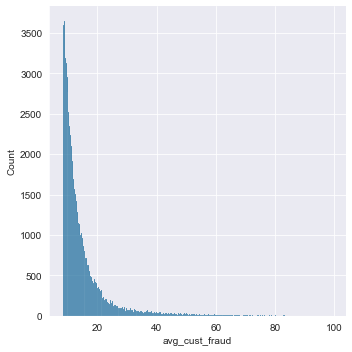

In [42]:
pandas_df2 = agg_probability2.toPandas()

sns.set_style("darkgrid")
sns.set_palette("PuBu_r")
sns.displot(pandas_df2["avg_cust_fraud"])